In [2]:
import numpy as np
import pandas as pd
from functools import reduce
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [5]:
path_models_ctm = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/models_htm_ctm")
path_models_mallet = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/models_htm")
path_models = path_models_ctm

In [40]:
dfs = []
for entry in path_models.iterdir():
    # check if it is a root model
    if "root" in entry.as_posix():
        thr = -1
        exp_tpc = -1
        iter_ = int(entry.as_posix().split("model_")[1].split("_")[0])
        path = entry
        cohrs = np.load(path.joinpath('TMmodel/topic_coherence.npy')).tolist()
        alphas = np.load(path.joinpath('TMmodel/alphas.npy')).tolist()
        tpc_ids = np.arange(0,len(alphas),1)
        root_tpc_df = pd.DataFrame(
            {'iter': [iter_] * len(alphas),
             'path': [path] * len(alphas),
             'cohrs': cohrs,
             'alphas': alphas,
             'tpc_ids': tpc_ids,
             'thr': [thr] * len(alphas),
             'exp_tpc': [exp_tpc] * len(alphas),
            })
        dfs.append(root_tpc_df)
df = pd.concat(dfs)
df = df.sort_values(by=['iter'])
df

,iter,path,cohrs,alphas,tpc_ids,thr,exp_tpc
5,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.643776,0.099939,5,-1,-1
4,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.630698,0.100076,4,-1,-1
1,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.714898,0.103483,1,-1,-1
6,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.714726,0.097570,6,-1,-1
7,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.583838,0.096334,7,-1,-1
...,...,...,...,...,...,...,...
4,19,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.667593,0.100308,4,-1,-1
6,19,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.686649,0.097767,6,-1,-1
7,19,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.582086,0.097599,7,-1,-1
9,19,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.609266,0.089415,9,-1,-1


In [47]:
# Iter over each root model (according to its corresponding iteration, iter)
concats = [df]
not_finished = []
for el in df.iter.unique():
    path_root = df[df.iter == el].iloc[0].path
    for entry in path_root.iterdir():
        if entry.joinpath('TMmodel/topic_coherence.npy').is_file():
        
            if "ws" in entry.as_posix():
                thr = 0
            else:
                thr = float(entry.as_posix().split("thr_")[1].split("_")[0])

            # get topic from which the submodel is generated
            exp_tpc = int(entry.as_posix().split("from_topic_")[1].split("_")[0])

            # cohr submodel is the mean of the cohr of its topics
            cohr = np.mean(np.load(entry.joinpath('TMmodel/topic_coherence.npy')))

            # cohr submodel is the mean of the cohr of its topics
            alpha = np.mean(np.load(entry.joinpath('TMmodel/alphas.npy')))

            # add entry of submodel to dataframe
            root_tpc_df = pd.DataFrame(
                {'iter': el,
                 'path': entry,
                 'cohrs': cohrs,
                 'alphas': alpha,
                 'tpc_ids': tpc_ids,
                 'thr': [thr] * len(alphas),
                 'exp_tpc': [exp_tpc] * len(alphas)})
            concats.append(root_tpc_df)
        else:
            not_finished.append(entry)
df = pd.concat(concats)

In [48]:
df

,iter,path,cohrs,alphas,tpc_ids,thr,exp_tpc
0,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.643776,0.099939,5,-1,-1
1,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.630698,0.100076,4,-1,-1
2,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.714898,0.103483,1,-1,-1
3,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.714726,0.097570,6,-1,-1
4,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.583838,0.096334,7,-1,-1
...,...,...,...,...,...,...,...
5,19,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.72279,0.100000,5,0.1,4
6,19,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.698378,0.100000,6,0.1,4
7,19,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.727463,0.100000,7,0.1,4
8,19,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.51514,0.100000,8,0.1,4


In [96]:
df_root.groupby('tpc_ids')[['cohrs']].mean().values.tolist()

[[0.7353780392136275],
 [0.7013943494379592],
 [0.7069863686459109],
 [0.7116036126211883],
 [0.6925584331512683],
 [0.6981711305491929],
 [0.7314021152370181],
 [0.6847815699646775],
 [0.6778017608583293],
 [0.6829564009283432]]

In [102]:
df_root_2 = pd.DataFrame(
    {'tpc': np.arange(0,len(df_root.groupby('tpc_ids')[['cohrs']].mean()),1),
     'cohr_mean': df_root.groupby('tpc_ids')[['cohrs']].mean().values.tolist(),
     'cohr_var': df_root.groupby('tpc_ids')[['cohrs']].var().values.tolist(),
     'alphas_mean': df_root.groupby('tpc_ids')[['alphas']].mean().values.tolist(),
     'alphas_var': df_root.groupby('tpc_ids')[['alphas']].var().values.tolist()})
df_root_2

,tpc,cohr_mean,cohr_var,alphas_mean,alphas_var
0,0,[0.7353780392136275],[0.005250481189383725],[0.1091162670356568],[1.5459016485931878e-05]
1,1,[0.7013943494379592],[0.001956113549508094],[0.1052265811241772],[2.3361377039708192e-06]
2,2,[0.7069863686459109],[0.004359463787342629],[0.10316661186815781],[2.172714917471535e-06]
3,3,[0.7116036126211883],[0.0048788832424704965],[0.10155146048215383],[1.3424243940101219e-06]
4,4,[0.6925584331512683],[0.003749625075558634],[0.10031482469746851],[1.679740909118561e-06]
5,5,[0.6981711305491929],[0.006054198462152518],[0.09911566715366746],[1.0182074108775376e-06]
6,6,[0.7314021152370181],[0.0022412225247821944],[0.09793247237153577],[8.002939960632269e-07]
7,7,[0.6847815699646775],[0.0043735927997177685],[0.09657880660605807],[1.9631080766884116e-06]
8,8,[0.6778017608583293],[0.004365075601810431],[0.0949374948632179],[4.620389865800464e-06]
9,9,[0.6829564009283432],[0.004314911954870709],[0.09205981379790693],[4.086876700828938e-06]


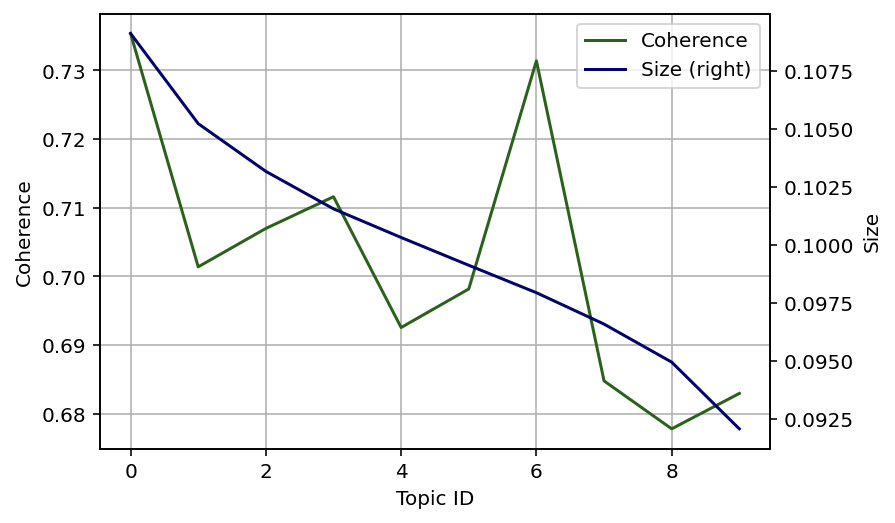

In [98]:
df_root = df[df.thr==-1]
ax = df_root.groupby('tpc_ids')[['cohrs']].mean().plot(
    y='cohrs', kind = 'line', label='Coherence',  color="#2a621b", use_index=True, stacked=True)
ax2 = df_root.groupby('tpc_ids')[['alphas']].mean().plot(
    ax=ax, y='alphas', kind = 'line', label='Size', color="#01026c", use_index=True, secondary_y=True)

ax.grid()
ax.set_xlabel('Topic ID')
ax.set_ylabel('Coherence')
ax2.set_ylabel('Size')
#plt.ylabel('Coherence')
plt.show()

In [ ]:
#https://towardsdatascience.com/error-bar-plots-from-a-data-frame-using-matplotlib-53026fe95491